# Scraping Multiple Pages

In [2]:
import pandas as pd

In [3]:
# read csv file
df = pd.read_csv('..\\data\\urldf2.csv')

<Axes: xlabel='has_pagination'>

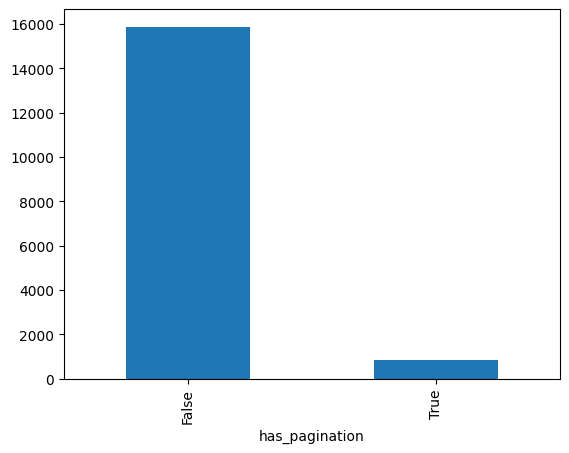

In [6]:
# visualize the has_pagination and is_event columns with bar plots
df['has_pagination'].value_counts().plot(kind='bar')

<Axes: xlabel='is_event'>

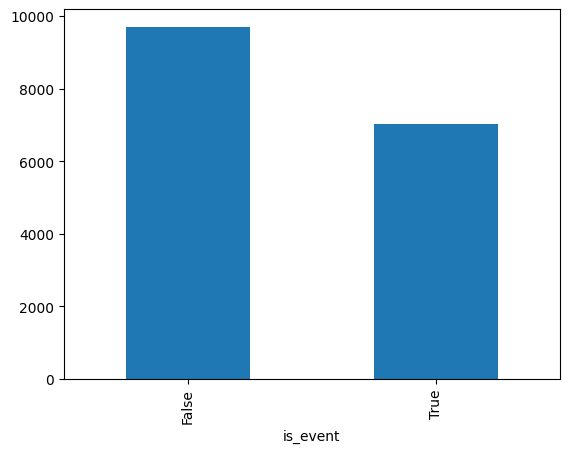

In [7]:

df['is_event'].value_counts().plot(kind='bar')

<Axes: xlabel='is_mp3'>

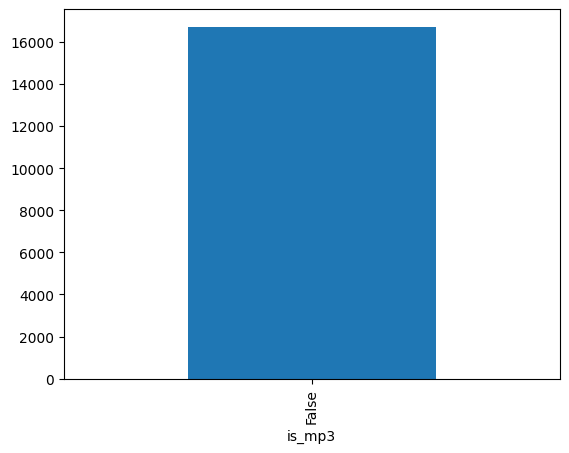

In [12]:
df['is_mp3'].value_counts().plot(kind='bar')

In [15]:
df_notpag = df[df['has_pagination'] == False]
df_ispag = df[df['has_pagination'] == True]

In [16]:
df_notpag.shape, df_ispag.shape

((15870, 4), (849, 4))

In [13]:
df_notpag_notevent = df_notpag[df_notpag['is_event'] == False]
df_notpag_is_event = df_notpag[df_notpag['is_event'] == True]

In [14]:
df_notpag_notevent.shape, df_notpag_is_event.shape

((8867, 4), (7003, 4))

In [17]:
# save the dataframes to csv files
df_notpag_notevent.to_csv('..\\data\\notpag_notevent.csv', index=False)
df_notpag_is_event.to_csv('..\\data\\notpag_is_event.csv', index=False)
df_ispag.to_csv('..\\data\\is_pagination.csv', index=False)

In [20]:
# check duplicates
print(df_notpag_notevent.duplicated().sum())
print(df_notpag_is_event.duplicated().sum())
print(df_ispag.duplicated().sum())


0
0
0


In [21]:
# check if URLs are unique
print(df_notpag_notevent['URLs'].duplicated().sum())
print(df_notpag_is_event['URLs'].duplicated().sum())
print(df_ispag['URLs'].duplicated().sum())

0
0
0


In [48]:
urls = df_notpag_notevent['URLs'].tolist()

In [75]:
# List of outdated or less useful file extensions and URL substrings
outdated_extensions = ['.asp', '.htm', '.html', '.jsp', '.php']
outdated_keywords = ['archive', 'old', 'news', 'tag','events'] # we will add news and events back in the future

# Creating a new list of cleaned URLs by excluding the outdated ones
cleaned_urls = [
    url for url in urls
    if not any(ext in url for ext in outdated_extensions)  # Check for file extensions
    and not any(keyword in url for keyword in outdated_keywords)  # Check for specific keywords
    and not url.endswith(tuple(outdated_extensions))  # Ensure URL doesn't end with any outdated extensions
]

In [77]:
len(cleaned_urls), len(urls)

(6345, 8867)

In [78]:
cleaned_urls

['https://wise.cgu.edu/wise-tutorials/tutorial-regression-analysis/module-3-the-impact-of-an-outlier/',
 'https://my.cgu.edu/transdisciplinary/leadership-outside-the-lines/',
 'https://my.cgu.edu/registrar/students/',
 'https://myplannedgift.cgu.edu/endowed-gifts',
 'https://wise.cgu.edu/wise-tutorials/tutorial-central-limit-theorem/clt-activity-1/',
 'https://www.cgu.edu/give/fellowships/annual-fellowships/',
 'https://my.cgu.edu/facilities/home/stauffercgu/',
 'https://www.cgu.edu/people/c-anderson-johnson/',
 'https://research.cgu.edu/drucker-customer-lab/empowering-leaders/',
 'https://research.cgu.edu/paul-gray-pc-museum/2022/10/',
 'https://my.cgu.edu/writing-rhetoric/about/staff/',
 'https://mormonstudies.cgu.edu/students/student-writings/unique-but-familiar/',
 'https://mli.cgu.edu/you-xiao/',
 'https://mli.cgu.edu/schenk-joe/',
 'https://wise.cgu.edu/signal-detection-d-defined',
 'https://scholar.cgu.edu/marina-chugunova',
 'https://www.cgu.edu/departments/history/',
 'https:/

In [79]:
# save the cleaned URLs to a csv file
df_cleaned_urls = pd.DataFrame(cleaned_urls, columns=['URLs'])
df_cleaned_urls.to_csv('..\\data\\cleaned_urls.csv', index=False)

In [80]:
from urllib.parse import urlparse

In [81]:
# Extract subdomains and add as a new column
df_cleaned_urls['Subdomain'] = df_cleaned_urls['URLs'].apply(lambda url: urlparse(url).hostname.split('.')[0])

# Define subdomains to remove
subdomains_to_remove = ['wise', 'wise1', 'my', 'cgu', 'sis', 'brand',
                         'mycampus', 'bot', 'gli', 'mli', 'arts','admissions',
                         'drucker','tei']

# Further clean the URLs by removing those with specified subdomains
df_cleaned_urls_filtered = df_cleaned_urls[~df_cleaned_urls['Subdomain'].isin(subdomains_to_remove)]

In [82]:
df_cleaned_urls_filtered.shape

(2883, 2)

In [83]:
df_cleaned_urls_filtered['Subdomain'].value_counts()

Subdomain
research         1175
www              1106
mormonstudies     165
flame             136
info              105
scholar            99
myplannedgift      91
online              4
bulletin            2
Name: count, dtype: int64

In [84]:
final_urls = df_cleaned_urls_filtered['URLs'].tolist()

In [112]:
import os
# split the URLs into every 700 URLs and then save the chunks
n = 700
chunks = [final_urls[i * n:(i + 1) * n] for i in range((len(final_urls) + n - 1) // n)]

for i, chunk in enumerate(chunks):
    df_chunk = pd.DataFrame(chunk, columns=['URLs'])
    # create the dir
    os.makedirs('..\\data\\chunks', exist_ok=True)
    df_chunk.to_csv(f'..\\data\\chunks\\final_urls_{i}.csv', index=False)

# Start from here

In [1]:
import requests
from langchain_core.documents import Document

def scrape_jina_ai(url: str) -> Document:
    response = requests.get("https://r.jina.ai/" + url)
    # Find the start of the Markdown Content section and get everything after it
    markdown_start = response.text.find('Markdown Content:') + len('Markdown Content:')
    markdown_content = response.text[markdown_start:].strip()  # Get all content after the header
    
    sections = response.text.split('\n\n')  # This split is for getting title and URL
    title = sections[0].strip().replace('Title: ', '')
    url_source = sections[1].strip().replace('URL Source: ', '')
    
    # Tokenize the markdown content to check its length
    tokens = markdown_content.split()
    if len(tokens) < 50:  # Set a minimum token threshold, e.g., 50 tokens
        return None

    # Create a Document object with appropriate metadata
    doc = Document(
        page_content=markdown_content,  # Full markdown content
        metadata={
            'title': title,
            'url': url_source
        }
    )
    return doc

In [3]:
import pandas as pd

chunk_url = pd.read_csv('final_urls_1.csv')

In [4]:
chunk_url.head()

,URLs
0,https://www.cgu.edu/school/institute-of-mathem...
1,https://www.cgu.edu/admissions/meet-our-team/)
2,https://research.cgu.edu/wincart/cancer-educat...
3,https://www.cgu.edu/school/drucker-school-of-m...
4,https://info.cgu.edu/podcasts/podcast/this-epi...


In [5]:
urls = chunk_url['URLs'].tolist()
urls

['https://www.cgu.edu/school/institute-of-mathematical-sciences/faculty/',
 'https://www.cgu.edu/admissions/meet-our-team/)',
 'https://research.cgu.edu/wincart/cancer-education/',
 'https://www.cgu.edu/school/drucker-school-of-management/drucker-alumni/how-to-give/',
 'https://info.cgu.edu/podcasts/podcast/this-episode-features-the-story-of-kalani-who-navigated-membership-in-the-church-during-times-when-interracial-marriage-was-discouraged/',
 'https://research.cgu.edu/cultural-property-disputes-resource/cpdr/19th-century-regalia-of-a-blackfoot-nation-leader-crowfoot/',
 'https://www.cgu.edu/event/cgu-campus-tours-31/',
 'https://www.cgu.edu/admissions/how-to-apply/applicant-faq/',
 'https://scholar.cgu.edu/samir-chatterjee/home/hobby-music/',
 'https://flame.cgu.edu/yvonne-mills/',
 'http://www.cgu.edu/admissions/international-applicants/',
 'https://www.cgu.edu/academics/program/innovation-systems-design-business-administration/',
 'https://flame.cgu.edu/on-home-a-novel/',
 'https:/

In [7]:
# Scrape documents
docs_list = []
for url in urls:
    doc = scrape_jina_ai(url)
    if doc is not None:
        docs_list.append(doc)

print(f"Total documents scraped successfully: {len(docs_list)}")

Total documents scraped successfully: 695


In [8]:
# remove the None values
docs_list = [doc for doc in docs_list if doc is not None]

In [9]:
docs_list

[Document(page_content='### The Institute for Mathematical Sciences (IMS) is home to renowned faculty conducting top-level research in their fields of study. IMS faculty provide students personalized attention and professional mentorship, collaborating with and guiding them through the graduate school experience.\n\n##### Core and Associate Faculty\n\n![Image 1: John Angus profile image](https://www.cgu.edu/wp-content/uploads/2016/11/Angus_John_1000-600x600.jpg)\n\n#### John Angus\n\nProfessor of Mathematics  \nDirector, Institute of Mathematical Sciences\n\n![Image 2: Yu Bai profile image](https://www.cgu.edu/wp-content/uploads/2023/07/Yu-Bai-600x600.jpg)\n\n#### Yu Bai\n\nResearch Associate Professor\n\n![Image 3: Marina Chugunova profile image](https://www.cgu.edu/wp-content/uploads/2016/11/Chugunova_Marina_1000-600x600.jpg)\n\n#### Marina Chugunova\n\nEllis Cumberbatch Professor of Mathematics  \nProgram Director, PhD in Engineering & Computational Mathematics\n\n![Image 4: Hrushik

In [12]:
len(docs_list)

695

In [10]:
# Split the documents into chunks
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1024, chunk_overlap=20
)
doc_splits = text_splitter.split_documents(docs_list)

In [11]:
import json

def document_to_json(document):
    # Assuming the document has attributes like content and metadata
    return json.dumps({
        'page_content': document.page_content,
        'metadata': document.metadata
    })

# Convert split documents to JSON
json_splits = [document_to_json(doc) for doc in doc_splits]

# Save the JSON data to a file # change your file name
with open('split_documents.json', 'w') as file:
    json.dump(json_splits, file)

In [ ]:
# def json_to_document(json_str):
#     data = json.loads(json_str)
#     # Reconstruct the Document object
#     return Document(page_content=data['page_content'], metadata=data['metadata'])

# # Load the JSON data
# with open('split_documents.json', 'r') as file:
#     loaded_json_splits = json.load(file)

# # Convert JSON back to Document objects
# loaded_doc_splits = [json_to_document(json_str) for json_str in loaded_json_splits]